## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

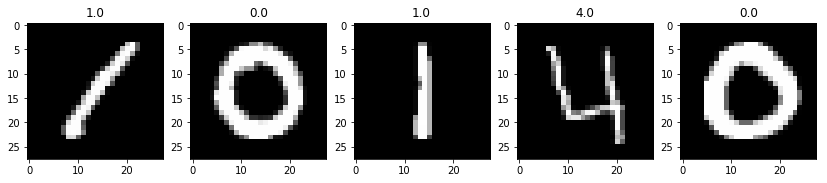

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=9)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=9)

In [26]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=9)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=9)

## Вычисляем угол и длину вектора градиента

In [27]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [28]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

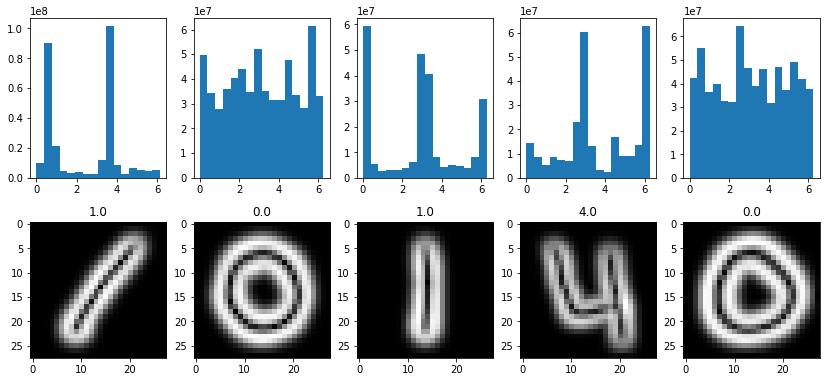

In [29]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [30]:
# Гистограммы вычисляются с учетом длины вектора градиента

### bins

train_hist = np.zeros((len(train_img), 100))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=100,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [31]:
test_hist = np.zeros((len(test_img), 100))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=100,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [32]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [33]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [34]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [35]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [36]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [37]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [38]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.486904761905


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.31      0.31      0.31       816
        1.0       0.72      0.76      0.74       909
        2.0       0.53      0.40      0.45       846
        3.0       0.53      0.55      0.54       937
        4.0       0.45      0.34      0.39       839
        5.0       0.47      0.65      0.54       702
        6.0       0.32      0.44      0.37       785
        7.0       0.58      0.56      0.57       893
        8.0       0.44      0.44      0.44       835
        9.0       0.54      0.41      0.47       838

avg / total       0.49      0.49      0.49      8400



In [40]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[250   9  53  54  66  60 177   2 130  15]
 [  2 692   3   0   7   0  77 120   2   6]
 [ 64   0 336 147  13 205  40  13  21   7]
 [ 54   0 118 513  13 132   2   1  78  26]
 [ 58  94   5  23 286   0 191  63  33  86]
 [ 29   0  78  85   2 457  11   1  38   1]
 [144  24  29  11  69  15 344  17 103  29]
 [ 36 106   1  28   4  43  96 498  27  54]
 [126   6   9  62  49  64  77   5 370  67]
 [ 38  33   8  48 124   5  65 136  37 344]]


## Предсказания на тестовыйх данных

In [41]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

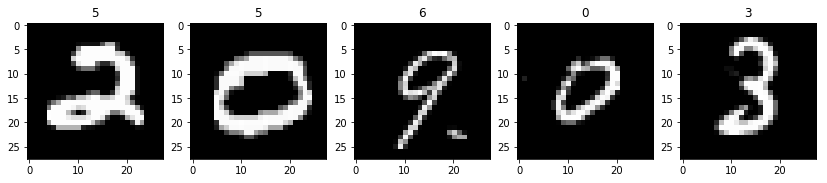

In [42]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [43]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [44]:
# Your submission scored 0.41700